In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from src.config import BLD, SRC

plt.rcParams.update(
    {
        "axes.spines.right": False,
        "axes.spines.top": False,
        "legend.frameon": False,
        "figure.figsize": [10.0, 6.0],
    }
)

# Prepare the Logged Data

In [2]:
def read_log(path, key, name):
    """From the log path of one simulation get a tidy df.

    Args:
        path (pathlib.Path): path to the log of one simulation.
            key (str): key of the pickled dict of each date whose
            value we want to concatenate over dates
        name (str): name of the value column in the returned
            DataFrame.

    Returns:
        df (pandas.DataFrame): tidy DataFrame. Columns are
            "date", "age_group_rki" and **name**.

    """
    date_paths = path.iterdir()
    to_concat = []
    for path in date_paths:
        date_entry = pd.read_pickle(path)
        date = path.name[:-4]
        to_concat.append(_process_sr(date_entry[key], date))
    df = _combine_dates(to_concat, name)
    return df


def _process_sr(sr, date):
    try:
        out = sr.astype(int)
    except ValueError:
        out = sr
    out.name = pd.Timestamp(date)
    return out


def _combine_dates(date_series, name):
    """Concatenate and tidy up a list of Series.

    Args:
        date_series (list): list of Series. The
            names are the dates. Indices are the
            RKI age groups.
        name (str): name of the value column of
            the finished long and tidy DataFrame.

    """
    wide = pd.concat(date_series, axis=1).T
    wide.columns = wide.columns.as_ordered()
    wide.index.name = "date"
    wide.index.name = "date"
    long_sr = wide.stack()
    long_sr.name = name
    long_df = long_sr.reset_index()
    return long_df

In [3]:
# switch here between fall and spring
second_path_part = "verify_main_fall_scenarios/test_demand_logging/base_scenario_300000"

# This is the path that should work when opening this Notebook on the IZA Server
log_path = BLD / "simulations" / second_path_part

# This is the path for running on the local machine
iza_download_path = Path(
    "/home/klara/Dropbox/Projects/covid/results_sid_germany/"
    + "2021-04-23_3_log_implied_known_share_cases"
)
log_path = iza_download_path / second_path_part

In [4]:
example_entry = pd.read_pickle(log_path / "2020-11-02.pkl")
example_entry.keys()

dict_keys(['n_pos_tests_for_each_group', 'demands_by_age_group', 'symptomatic_requests', 'receiving_confirmation', 'scaled', 'implied_share_known_cases', 'supply_inputs'])

In [5]:
# all of these are tidy dfs with "date", "age_group_rki" and the **name**
supply = read_log(log_path, key="n_pos_tests_for_each_group", name="supply")
unconstrained = read_log(log_path, key="demands_by_age_group", name="unconstrained")
symptom_requests = read_log(log_path, key="symptomatic_requests", name="symptomatics")
after_rapid_requests = read_log(
    log_path, key="receiving_confirmation", name="after_rapid_requests"
)
scaled = read_log(log_path, key="scaled", name="scaled")

# Scaling works!
pd.testing.assert_series_equal(
    supply.set_index(["date", "age_group_rki"])["supply"],
    scaled.set_index(["date", "age_group_rki"])["scaled"],
    check_names=False,
)

supply.head()

,date,age_group_rki,supply
0,2020-10-15,0-4,4
1,2020-10-15,5-14,15
2,2020-10-15,15-34,93
3,2020-10-15,35-59,100
4,2020-10-15,60-79,41


In [6]:
# 0.8 for 0-4 in the fall.
# No zeros in the spring.
share_of_zeros_in_supply = supply[supply["supply"] == 0]["age_group_rki"].value_counts(
    normalize=True
)
share_of_zeros_in_supply.round(2).sort_index()

0-4       1.0
5-14      0.0
15-34     0.0
35-59     0.0
60-79     0.0
80-100    0.0
Name: age_group_rki, dtype: float64

# Plot Time Series

In [7]:
from sid.colors import get_colors

colors = get_colors("ordered", 6)
sns.set_palette(colors)

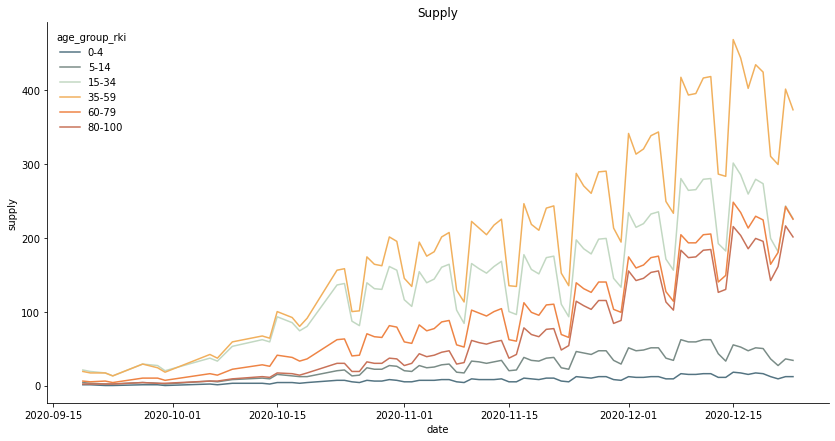

In [8]:
fig, ax = plt.subplots(figsize=(14, 7))
sns.lineplot(
    data=supply,
    x="date",
    y="supply",
    hue="age_group_rki",
)
ax.set_title("Supply")
plt.show()

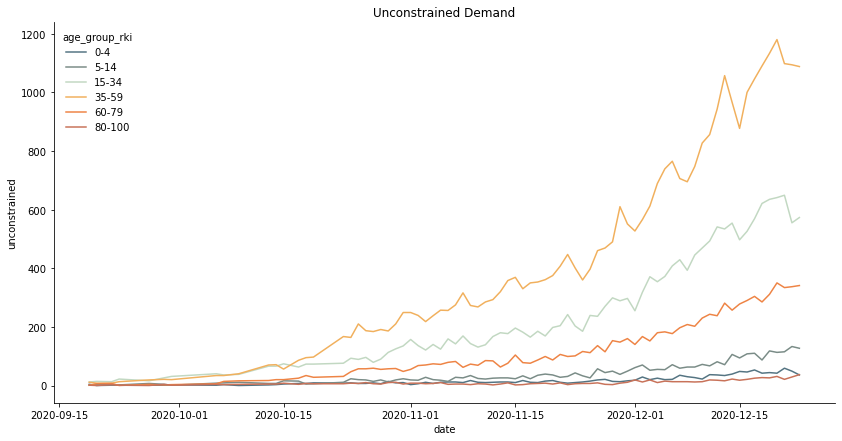

In [9]:
fig, ax = plt.subplots(figsize=(14, 7))
sns.lineplot(
    data=unconstrained,
    x="date",
    y="unconstrained",
    hue="age_group_rki",
)
ax.set_title("Unconstrained Demand")
plt.show()

# Plot Demand To Supply Share

In [10]:
def _sum_over_week(df, col):
    grouper = [pd.Grouper(key="date", freq="W"), "age_group_rki"]
    # add 0.1 to avoid infs and NaN
    summed = df.groupby(grouper)[col].sum().fillna(0) + 0.1
    return summed

In [11]:
demand_to_supply = _sum_over_week(unconstrained, "unconstrained") / _sum_over_week(
    supply, "supply"
)
demand_to_supply.name = "demand_to_supply"

wide_demand_to_supply = demand_to_supply.unstack("age_group_rki")

wide_demand_to_supply.head().round(1)

age_group_rki,0-4,5-14,15-34,35-59,60-79,80-100
date,,,,,,
2020-09-20,2.0,0.7,0.7,0.5,0.6,0.3
2020-09-27,2.8,1.2,0.9,0.7,0.6,0.5
2020-10-04,2.8,1.0,1.2,1.0,0.3,0.8
2020-10-11,0.7,1.5,0.9,0.8,0.7,0.5
2020-10-18,1.5,0.8,0.9,0.9,0.7,0.4


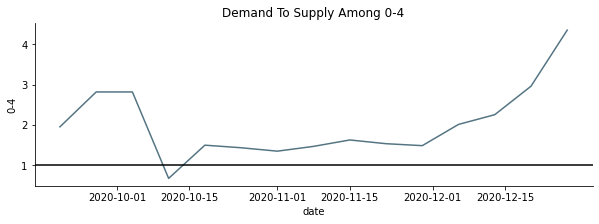

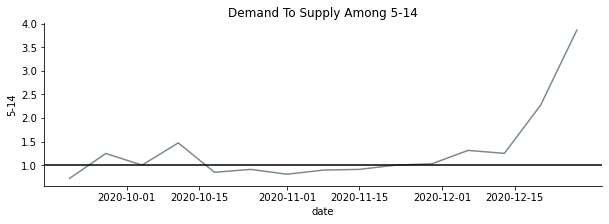

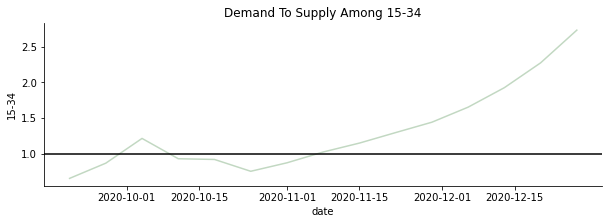

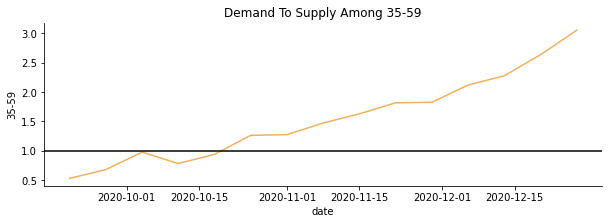

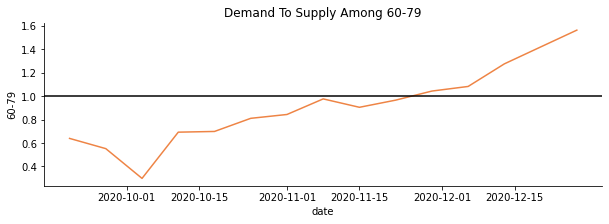

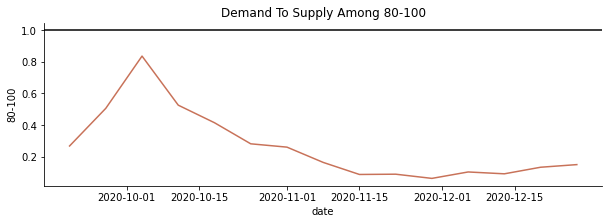

In [12]:
# Above 1 means there is excess demand and we had to do down scaling.

for i, col in enumerate(wide_demand_to_supply):
    fig, ax = plt.subplots(figsize=(10, 3))
    sns.lineplot(
        x=wide_demand_to_supply.index, y=wide_demand_to_supply[col], color=colors[i]
    )
    ax.set_title(f"Demand To Supply Among {col}")
    ax.axhline(1, color="k")
    if ax.get_ylim()[1] > 5:
        ax.set_ylim(0, 5)

# Plot Demand and Supply for Each Age Group

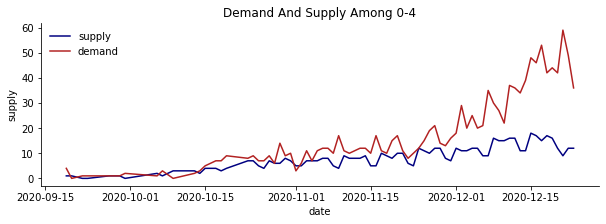

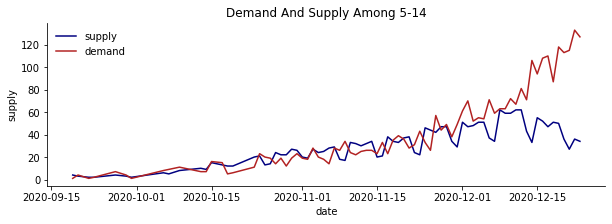

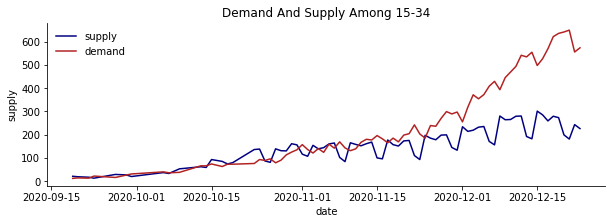

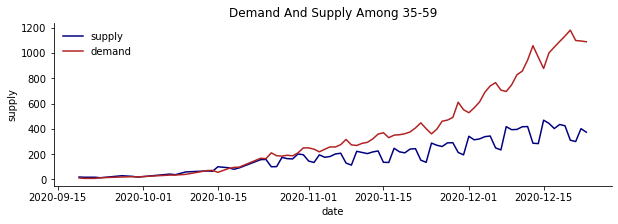

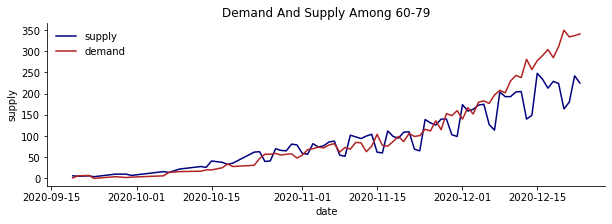

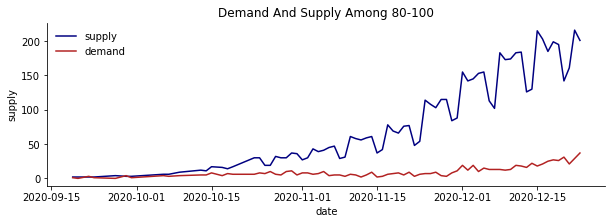

In [13]:
for i, group in enumerate(supply["age_group_rki"].unique()):
    s = supply[supply["age_group_rki"] == group]
    d = unconstrained[unconstrained["age_group_rki"] == group]
    fig, ax = plt.subplots(figsize=(10, 3))
    sns.lineplot(data=s, x="date", y="supply", color="navy", label="supply")
    sns.lineplot(data=d, x="date", y="unconstrained", color="firebrick", label="demand")
    ax.set_title(f"Demand And Supply Among {group}")
    plt.legend()

# Implied and Other Share Known Cases

In [14]:
implied_share_known_cases = read_log(
    log_path, key="implied_share_known_cases", name="implied_share_known_cases"
)

In [15]:
from src.testing.shared import get_share_known_cases_series

params = pd.read_pickle(BLD / "params.pkl")
given_share_known_cases = get_share_known_cases_series(
    params.loc[("share_known_cases", "share_known_cases")]
)

implied_dates = implied_share_known_cases["date"].unique()
given_share_known_cases = given_share_known_cases.loc[implied_dates]

<ipython-input-15-735e25a2c488>:3: PerformanceWarning: indexing past lexsort depth may impact performance.
  given_share_known_cases = get_share_known_cases_series(params.loc[("share_known_cases", "share_known_cases")])


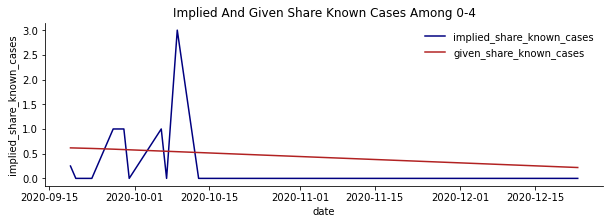

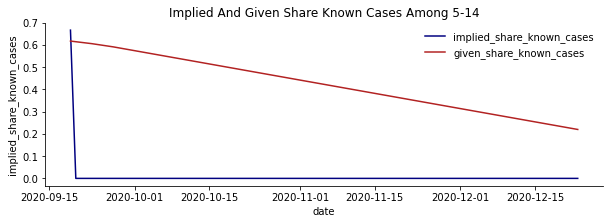

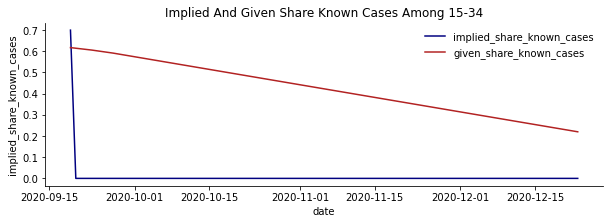

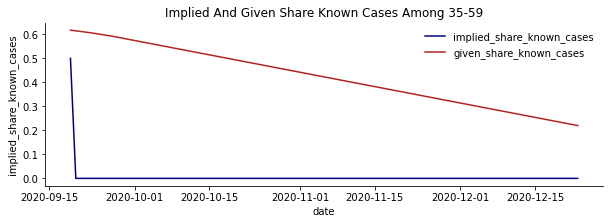

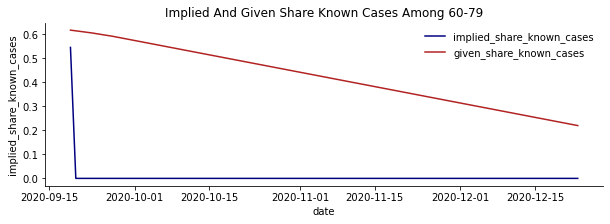

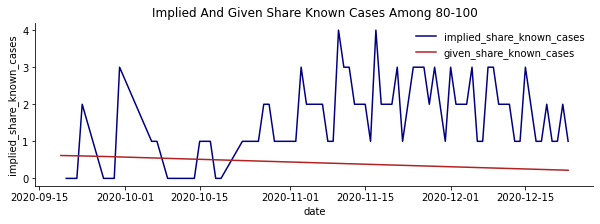

In [16]:
for i, group in enumerate(supply["age_group_rki"].unique()):
    s = implied_share_known_cases[implied_share_known_cases["age_group_rki"] == group]
    fig, ax = plt.subplots(figsize=(10, 3))
    sns.lineplot(
        data=s,
        x="date",
        y="implied_share_known_cases",
        color="navy",
        label="implied_share_known_cases",
    )
    sns.lineplot(
        x=given_share_known_cases.index,
        y=given_share_known_cases,
        color="firebrick",
        label="given_share_known_cases",
    )
    ax.set_title(f"Implied And Given Share Known Cases Among {group}")
    plt.legend()

In [17]:
implied_sr = implied_share_known_cases.set_index(["date", "age_group_rki"])[
    "implied_share_known_cases"
]
wide_implied_share_known_cases = implied_sr.unstack("age_group_rki")

# inf ~ no infected individuals in that group and day
# NaN ~ no infected individuals in that group and day and
#       no positive tests to assign to that group on that day

wide_implied_share_known_cases.round(1)

age_group_rki,0-4,5-14,15-34,35-59,60-79,80-100
date,,,,,,
2020-09-19,0.2,0.7,0.7,0.5,0.5,inf
2020-09-20,0.0,0.0,0.0,0.0,0.0,0.0
2020-09-22,0.0,0.0,0.0,0.0,0.0,0.0
2020-09-23,0.0,0.0,0.0,0.0,0.0,2.0
2020-09-27,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...
2020-12-19,0.0,0.0,0.0,0.0,0.0,2.0
2020-12-20,0.0,0.0,0.0,0.0,0.0,1.0
2020-12-21,0.0,0.0,0.0,0.0,0.0,1.0
